## Trading Strategy Back Testing System
This system will be composed of the following components
- Trading Strategy/Signals
- Performance calculation
- Portfolio

This code is influenced and based on the book "Successful Algorithmic Trading" by Mike Halls-Moore. For further detaisl go to:https://www.quantstart.com/successful-algorithmic-trading-ebook


In [21]:
import pandas as pd
import numpy as np

### Some Helper functions

In [146]:
def getDictFrom2ColDataFrame(df, index_col, other_col):
    direction = df[[index_col, other_col]]
    direction_dict = {k: list(v)[0] for k, v in direction.groupby(index_col)[other_col]}
    return direction_dict

### Strategy Interface

In [147]:
from abc import ABCMeta, abstractmethod
from enum import Enum

class TradeSignal(Enum):
    """
    Trade Signal
    """
    Long = 1
    Short = 2
    Hold = 3

class Strategy(object):
    """
    Strategy is an abstract base class providing an interface for
    all subsequent (inherited) strategy handling objects.

    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.

    This is designed to work both with historic and live data as
    the Strategy object is agnostic to where the data came from,
    since it obtains the bar tuples from a queue object.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def calculateSignals(self):
        """
        Provides the mechanisms to calculate the list of signals.
        """
        raise NotImplementedError("Should implement calculate_signals()")
    
    @abstractmethod    
    def calculatePnl(self):
        """
        Computes the PnL after taking a long position
        """
        raise NotImplementedError("Should implement calculatePnl()")
        
    @abstractmethod    
    def calculateReturns(self):
        """
        Computes the PnL after taking a long position
        """
        raise NotImplementedError("Should implement calculateReturns()")
        
        
class BuyAndHoldStrategy(Strategy):
    """
    Buy and Hold strategy: Take a long position and keep hold of the stock for a duration
    """
    def __init__(self, test_feature_data):
        self._signals = {}
        self._signals_dict = {}
        self._test_feature_data = test_feature_data
        self._pnl = {}
        self._return = {}
    
    def calculateSignals(self, directions, hold_period=None, index_col='date', other_col='signal'):
        self._signals = directions.copy()
        self._signals['signal'] = np.where((self._signals.direction == 1.0), TradeSignal.Long, TradeSignal.Hold)        
        #print(self._signals.head(5))
        self._signals_dict = getDictFrom2ColDataFrame(self._signals, index_col, other_col)        
        return self._signals, self._signals_dict
    
    def calculatePnl(self, open_column, close_column, date_column):
        for k in self._signals_dict.keys():
            open_price = self._test_feature_data[self._test_feature_data[date_column] == k][open_column].tolist()[0]
            close_price = self._test_feature_data[self._test_feature_data[date_column] == k][close_column].tolist()[0]
            if self._signals_dict[k] == TradeSignal.Long:
                num_signal = 1.0 
            else:
                num_signal = 0.0
            self._pnl[k] = float(close_price - open_price)*num_signal
            #print("close_price = {0} open_price = {1} date = {2} num_signal = {3}".format(close_price, open_price, k, num_signal))
        return self._pnl
    
    def calculateReturns(self, return_column, date_column):
        for k in self._signals_dict.keys():
            return_price = self._test_feature_data[self._test_feature_data[date_column] == k][return_column].tolist()[0]
            if self._signals_dict[k] == TradeSignal.Long:
                num_signal = 1.0 
            else:
                num_signal = 0.0
            self._return[k] = float(return_price)*num_signal
        return self._return
    


### Test Trading Strategy

In [173]:
data_path = ".\Data\GOOGL.csv"
test_data = pd.read_csv(data_path)
test_data = test_data[test_data.date > '2017-12-30']
test_data['direction'] = np.sign(test_data['4. close'].pct_change())
test_data['return'] = test_data['4. close'].pct_change()
test_data = test_data.dropna()
test_data.head(2)

def getDirectionDict(test_data):
    direction_dict = getDictFrom2ColDataFrame(test_data, index_col='date', other_col='direction')
    return direction_dict

def testStrategy():
    strategy = BuyAndHoldStrategy(test_data)
    #directions = getDirectionDict(test_data)
    directions = test_data[['date', 'direction']]
    signals, signals_dict = strategy.calculateSignals(directions)
    pnl = strategy.calculatePnl(open_column = '1. open', close_column = '4. close', date_column = 'date')
    returns = strategy.calculateReturns(return_column='return', date_column = 'date')
    print("Number the firtst 5 signals, pnl and returns are:")
    dates = list(signals_dict.keys())
    for i,k in enumerate(dates[:5]):
        print("Signals[{0}] = {1}".format(k, signals_dict[k]))
        print("pnl[{0}] = {1}".format(k, pnl[k]))
        print("returns[{0}] = {1}".format(k, returns[k]))
        print("\n")
    
testStrategy()

Number the firtst 5 signals, pnl and returns are:
Signals[2018-02-05] = TradeSignal.Hold
pnl[2018-02-05] = -0.0
returns[2018-02-05] = -0.0


Signals[2018-01-24] = TradeSignal.Hold
pnl[2018-01-24] = -0.0
returns[2018-01-24] = -0.0


Signals[2018-01-08] = TradeSignal.Long
pnl[2018-01-08] = 3.2100000000000364
returns[2018-01-08] = 0.003530609120139916


Signals[2018-03-20] = TradeSignal.Hold
pnl[2018-03-20] = -0.0
returns[2018-03-20] = -0.0


Signals[2018-01-04] = TradeSignal.Long
pnl[2018-01-04] = -1.3299999999999272
returns[2018-01-04] = 0.003884491351509922




### Trading Strategy Performance estimation

In [232]:
import numpy as np
import pandas as pd
from __future__ import print_function

class PerformanceEstimation(object):
    """
    """
    
    @staticmethod
    def computeSharpeRatio(returns, periods=252):
        """
        Create the Sharpe ratio for the strategy, based on a 
        benchmark of zero (i.e. no risk-free rate information).

        Parameters:
        returns - A pandas Series representing period percentage returns.
        periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
        """
        return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)
    
    @staticmethod
    def computeDrawdowns(pnl):
        """
        Calculate the largest peak-to-trough drawdown of the PnL curve
        as well as the duration of the drawdown. Requires that the 
        pnl_returns is a pandas Series.

        Parameters:
        pnl - A pandas Series representing period percentage returns.

        Returns:
        drawdown, duration - Highest peak-to-trough drawdown and duration.
        """

        # Calculate the cumulative returns curve 
        # and set up the High Water Mark
        hwm = [0]

        # Create the drawdown and duration series
        idx = pnl.index
        drawdown = pd.Series(index = idx)
        duration = pd.Series(index = idx)

        # Loop over the index range
        for t in range(1, len(idx)):
            hwm.append(max(hwm[t-1], pnl.iloc[t]))
            drawdown[t]= (hwm[t]-pnl.iloc[t])
            duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
        return drawdown, drawdown.max(), duration.max()

### Create a simple portfolio which can generate orders and manages the profit and loss

In [239]:
%matplotlib inline
import matplotlib.pyplot as plt

class Portfolio(object):
    
    def __init__(self, initial_capital, signals, test_data, num_buy_shares, ticker,close_col, signal_col):
        self._initial_capital = initial_capital
        self._signals = signals
        self._test_data = test_data
        self._num_buy_shares = num_buy_shares
        self._ticker = ticker
        self._close_col = close_col
        self._signal_col = signal_col
        self._portfolio = None
        self._equity_curve = None
        self._stats = None
        
    def generatePortfolioPnl(self):
        # Create a DataFrame for the traded positions 
        positions = pd.DataFrame(index=self._signals.index).fillna(0.0)

        # Buy a 100 shares
        
        positions[self._ticker] = self._num_buy_shares*self._signals[self._signal_col]   

        # Initialize the portfolio with value owned
        self._portfolio = positions.multiply(test_data[self._close_col], axis=0)
        self._portfolio.reindex(index=test_data.date)
        self._portfolio['date'] = pd.to_datetime(test_data['date'])
        
        # Store the difference in shares owned 
        pos_diff = positions.diff()

        # Add `holdings` to portfolio
        self._portfolio['holdings'] = (positions.multiply(test_data[self._close_col], axis=0)).sum(axis=1)

        # Add `cash` to portfolio
        self._portfolio['cash'] = self._initial_capital - (pos_diff.multiply(test_data[self._close_col], axis=0)).sum(axis=1).cumsum()   

        # Add `total` to portfolio
        self._portfolio['total'] = self._portfolio['cash'] + self._portfolio['holdings']

        # Add `returns` to portfolio
        self._portfolio['returns'] = self._portfolio['total'].pct_change()
        
        # Remove Nan colums
        self._portfolio = self._portfolio.dropna()

        # Print the first lines of `portfolio`
        print("Portfolio Details (some rows):\n\n{}\n".format(self._portfolio.head()))
                
    def visualizePortfolio(self):
        # Create a figure
        fig = plt.figure()

        ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
        

        # Plot the equity curve in dollars
        self._portfolio['total'].plot(ax=ax1, lw=2.)

        ax1.plot(self._portfolio.loc[self._signals.direction == 1.0].index, 
                 self._portfolio.total[self._signals.direction == 1.0],
                 '^', markersize=10, color='m')
        ax1.plot(self._portfolio.loc[self._signals.direction == -1.0].index, 
                 self._portfolio.total[self._signals.direction == -1.0],
                 'v', markersize=10, color='k')
        plt.title("Equity Curve")
        # Show the plot
        plt.show()
        
    def visualizeEquityCurve(self):
        # Create a figure
        fig = plt.figure()

        ax1 = fig.add_subplot(111, ylabel='Equity Curve $')

        # Plot the equity curve in dollars
        self._equity_curve['equity_curve'].plot(ax=ax1, lw=2.)

        ax1.plot(self._equity_curve.index, 
                 self._equity_curve['equity_curve'], color='b')
        # Show the plot
        plt.show()
        
    def generateEquityCurve(self):
        """
        """
        """
        Creates a pandas DataFrame from the all_holdings
        list of dictionaries.
        """
        curve = self._portfolio.copy()
        #curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0+curve['returns']).cumprod()
        self._equity_curve = curve.dropna()
        print("Equity Curve Details (some rows):\n\n{}\n".format(self._equity_curve.head()))
        return self._equity_curve
        
    def outputSummaryStats(self):
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self._equity_curve['equity_curve'].iloc[-1]
        returns = self._equity_curve['returns']
        pnl = self._equity_curve['equity_curve']

        sharpe_ratio = PerformanceEstimation.computeSharpeRatio(returns, periods=252)
        drawdown, max_dd, dd_duration = PerformanceEstimation.computeDrawdowns(pnl)
        self._equity_curve['drawdown'] = drawdown

        self._stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]
        print("The Output Stats for thsi back test are:\n\n")
        for x in self._stats:
            print(x)
        print("\n")
        


### Test Created Trading Portfolio

Portfolio Details (some rows):

         GOOGL       date  holdings      cash     total   returns
3369  111029.0 2018-01-05  111029.0  100000.0  211029.0  0.006933
3370  111421.0 2018-01-08  111421.0  100000.0  211421.0  0.001858
3371 -111279.0 2018-01-09 -111279.0  322558.0  211279.0 -0.000672
3372 -111014.0 2018-01-10 -111014.0  322558.0  211544.0  0.001254
3373  111205.0 2018-01-11  111205.0  100148.0  211353.0 -0.000903



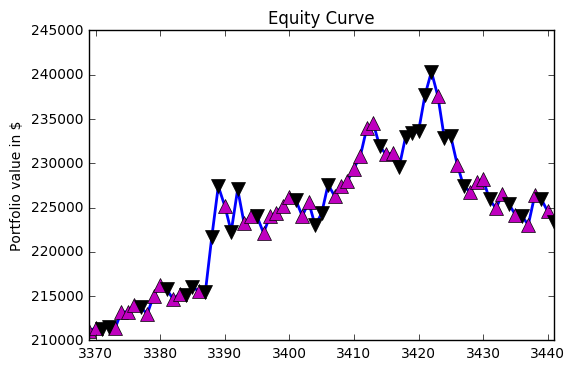

Equity Curve Details (some rows):

         GOOGL       date  holdings      cash     total   returns  \
3370  111421.0 2018-01-08  111421.0  100000.0  211421.0  0.001858   
3371 -111279.0 2018-01-09 -111279.0  322558.0  211279.0 -0.000672   
3372 -111014.0 2018-01-10 -111014.0  322558.0  211544.0  0.001254   
3373  111205.0 2018-01-11  111205.0  100148.0  211353.0 -0.000903   
3374  113065.0 2018-01-12  113065.0  100148.0  213213.0  0.008800   

      equity_curve  
3370      1.001858  
3371      1.001185  
3372      1.002440  
3373      1.001535  
3374      1.010349  

The Output Stats for thsi back test are:


('Total Return', '5.84%')
('Sharpe Ratio', '1.44')
('Max Drawdown', '8.19%')
('Drawdown Duration', '19')




In [241]:
strategy = BuyAndHoldStrategy(test_data)
directions = test_data[['date', 'direction']]
signals, signals_dict = strategy.calculateSignals(directions)
portfolio = Portfolio(
    initial_capital = 100000.0, 
    signals = signals, 
    test_data = test_data, 
    num_buy_shares = 100, 
    ticker = 'GOOGL',
    close_col = '4. close', 
    signal_col = 'direction')

portfolio.generatePortfolioPnl()
portfolio.visualizePortfolio()
equity_curve = portfolio.generateEquityCurve()
portfolio.outputSummaryStats()

